Grover's Algorithm Implementation and Testing

Test Case 1: 2-qubit Grover's Algorithm
Searching for state |11⟩ (decimal 3)
Optimal iterations: 1
Success probability: 1.0
Measurement results: {'11': 1024}

Test Case 2: 3-qubit Grover's Algorithm
Searching for |101⟩ and |110⟩ (decimal 5, 6)
Optimal iterations: 1
Success probability: 0.5126953125
Measurement results: {'101': 525, '011': 499}
Iterations: 1, Success probability: 0.000
Iterations: 2, Success probability: 0.269
Iterations: 3, Success probability: 0.227
Iterations: 4, Success probability: 0.000
Iterations: 5, Success probability: 0.235


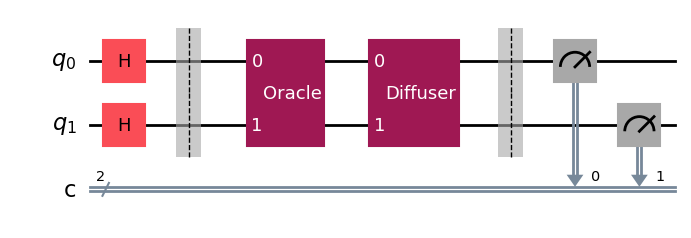

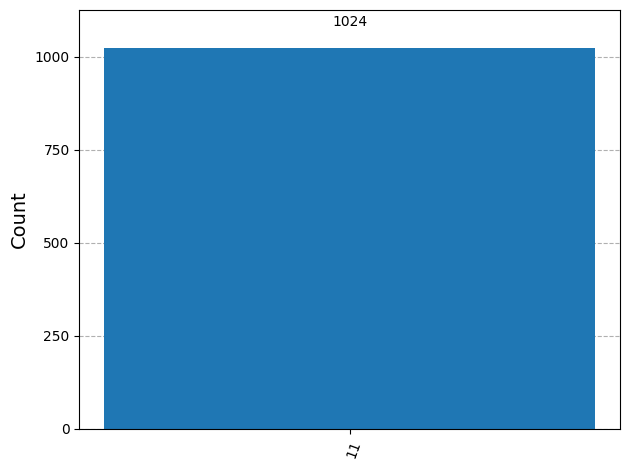

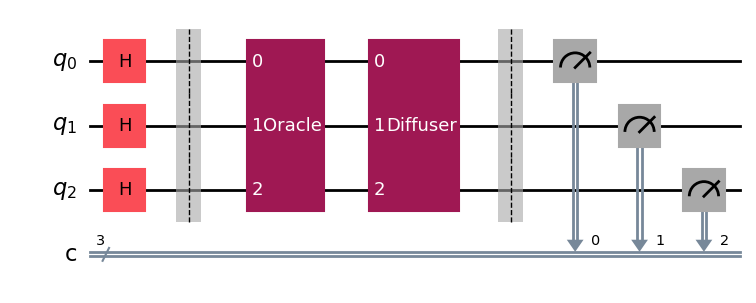

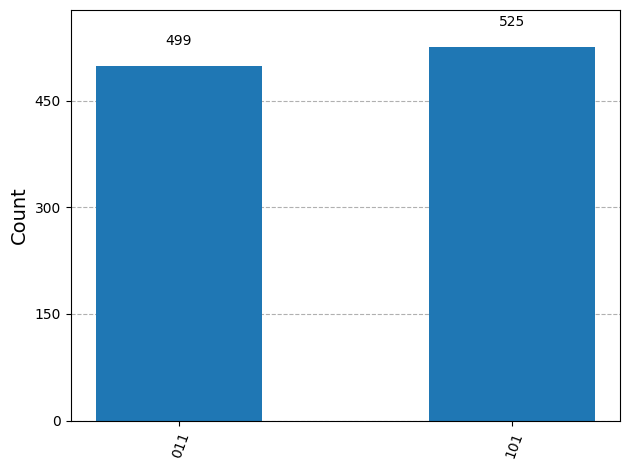

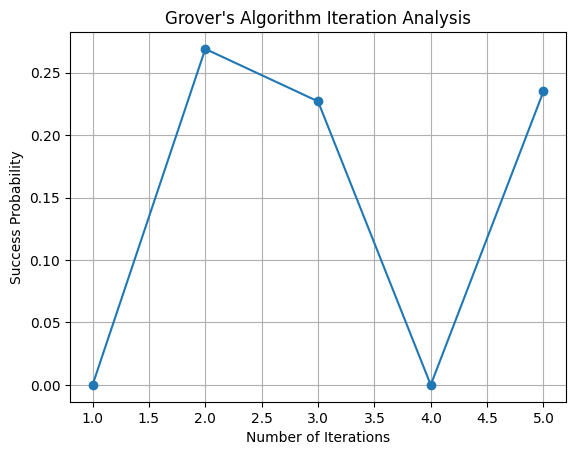

In [2]:
%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

class GroversAlgorithm:
    def __init__(self, n_qubits, target_states):
        self.n_qubits = n_qubits
        self.target_states = target_states
        self.N = 2**n_qubits
        self.M = len(target_states)
        
        if self.M == 1:
            self.optimal_iterations = int(np.pi/4 * np.sqrt(self.N) - 0.5)
        else:
            self.optimal_iterations = int(np.pi/4 * np.sqrt(self.N/self.M) - 0.5)
        self.optimal_iterations = max(1, self.optimal_iterations)
        
    def create_oracle(self):
        oracle = QuantumCircuit(self.n_qubits, name='Oracle')
        for target in self.target_states:
            binary_target = format(target, f'0{self.n_qubits}b')
            for i, bit in enumerate(binary_target):
                if bit == '0':
                    oracle.x(i)
            if self.n_qubits == 1:
                oracle.z(0)
            elif self.n_qubits == 2:
                oracle.cz(0, 1)
            elif self.n_qubits == 3:
                oracle.ccz(0, 1, 2)
            else:
                oracle.h(self.n_qubits - 1)
                oracle.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
                oracle.h(self.n_qubits - 1)
            for i, bit in enumerate(binary_target):
                if bit == '0':
                    oracle.x(i)
        return oracle
    
    def create_diffuser(self):
        diffuser = QuantumCircuit(self.n_qubits, name='Diffuser')
        diffuser.h(range(self.n_qubits))
        diffuser.x(range(self.n_qubits))
        if self.n_qubits == 1:
            diffuser.z(0)
        elif self.n_qubits == 2:
            diffuser.cz(0, 1)
        elif self.n_qubits == 3:
            diffuser.ccz(0, 1, 2)
        else:
            diffuser.h(self.n_qubits - 1)
            diffuser.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
            diffuser.h(self.n_qubits - 1)
        diffuser.x(range(self.n_qubits))
        diffuser.h(range(self.n_qubits))
        return diffuser
    
    def build_circuit(self, iterations=None):
        if iterations is None:
            iterations = self.optimal_iterations
        qreg = QuantumRegister(self.n_qubits, 'q')
        creg = ClassicalRegister(self.n_qubits, 'c')
        circuit = QuantumCircuit(qreg, creg)
        circuit.h(qreg)
        circuit.barrier()
        oracle = self.create_oracle()
        diffuser = self.create_diffuser()
        for i in range(iterations):
            circuit.append(oracle, qreg)
            circuit.append(diffuser, qreg)
            circuit.barrier()
        circuit.measure(qreg, creg)
        return circuit
    
    def run_simulation(self, shots=1024, iterations=None):
        circuit = self.build_circuit(iterations)
        simulator = AerSimulator()
        transpiled_circuit = transpile(circuit, simulator, optimization_level=1)
        job = simulator.run(transpiled_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()
        return counts, circuit
    
    def analyze_results(self, counts):
        total_shots = sum(counts.values())
        target_counts = 0
        for state_str, count in counts.items():
            state_int = int(state_str, 2)
            if state_int in self.target_states:
                target_counts += count
        success_probability = target_counts / total_shots
        return {
            'success_probability': success_probability,
            'target_counts': target_counts,
            'total_shots': total_shots,
            'target_states': self.target_states,
            'theoretical_max_prob': 1.0 if len(self.target_states) == 1 else len(self.target_states) / self.N
        }

def test_case_1():
    grover = GroversAlgorithm(n_qubits=2, target_states=[3])
    counts, circuit = grover.run_simulation(shots=1024)
    analysis = grover.analyze_results(counts)

    print("\nTest Case 1: 2-qubit Grover's Algorithm")
    print("Searching for state |11⟩ (decimal 3)")
    print("Optimal iterations:", grover.optimal_iterations)
    print("Success probability:", analysis['success_probability'])
    print("Measurement results:", counts)

    fig = circuit.draw("mpl")
    fig.savefig("circuit_test1.png")

    plot_histogram(counts).savefig("histogram_test1.png")

    return circuit, counts, analysis

def test_case_2():
    grover = GroversAlgorithm(n_qubits=3, target_states=[5, 6])
    counts, circuit = grover.run_simulation(shots=1024)
    analysis = grover.analyze_results(counts)

    print("\nTest Case 2: 3-qubit Grover's Algorithm")
    print("Searching for |101⟩ and |110⟩ (decimal 5, 6)")
    print("Optimal iterations:", grover.optimal_iterations)
    print("Success probability:", analysis['success_probability'])
    print("Measurement results:", counts)

    fig = circuit.draw("mpl")
    fig.savefig("circuit_test2.png")

    plot_histogram(counts).savefig("histogram_test2.png")

    return circuit, counts, analysis

def test_case_3():
    grover = GroversAlgorithm(n_qubits=2, target_states=[1])
    iterations_range = range(1, 6)
    probabilities = []
    for iterations in iterations_range:
        counts, _ = grover.run_simulation(shots=1000, iterations=iterations)
        analysis = grover.analyze_results(counts)
        probabilities.append(analysis['success_probability'])
        print(f"Iterations: {iterations}, Success probability: {analysis['success_probability']:.3f}")

    plt.figure()
    plt.plot(iterations_range, probabilities, marker='o')
    plt.xlabel("Number of Iterations")
    plt.ylabel("Success Probability")
    plt.title("Grover's Algorithm Iteration Analysis")
    plt.grid(True)
    plt.savefig("iteration_analysis.png")

    return iterations_range, probabilities

if __name__ == "__main__":
    print("Grover's Algorithm Implementation and Testing")

    circuit1, counts1, analysis1 = test_case_1()
    circuit2, counts2, analysis2 = test_case_2()
    iterations_range, probabilities = test_case_3()
